<a href="https://colab.research.google.com/github/kzheng18/Comp-590-776-Assignment4-Deep-Learning/blob/main/COMP590_776_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4. Deep learning

In this homework you will play with convolutional neural networks for image classification in PyTorch: write pieces of code for training/testing routine, train a simple baseline network, design your own architecture and pick parameters to beat the baseline, fine-tune a pre-trained deep neural net, and create a simple region proposal net.

The homework is graded out of 50 points:
1. (5 points) implement testing loop and measure accuracy;
2. (15 points) design your architecture and beat the baseline accuracy on the CIFAR-10 dataset (better accuracy -> more points);
3. (5 points) fine-tune ResNet-50 on the Dogs-vs-Cats dataset;
4. (5 points) use your model to create a simple region proposal net;
5. (20 points) write a report: answer the Questions 1-8 from the problem statement in your report, and discuss your results for TODO 1-4.


### Submission format:

1. Notebook with your work (shared link or `.ipynb`)
2. PDF report (attach just your answers to Questions 1-8 and a discussion of TODO 1-4, separately from the notebook code).

You can save a copy of this notebook in Colab and just submit the link, or download the `.ipynb` notebook and submit that way. Please make sure that your link is properly shared (it's best to pick "**everyone with the link can comment**"), or make sure that your `.ipynb` has all your outputs (there is an option to download just the code/text-only lightweight version).

Before you submit, make sure your notebook runs from start to end through **"Runtime -> Restart and Run all"**. If it doesn't, this likely means you executed cells out-of-order, or created variables with inconsistent names (e.g. one of the cells was using an output of a temporary variable from a cell that you deleted). Your results can also differ if you execute the training loop several times without resetting the network (making more epochs, which may result in a better result, but may also lead to overfitting).

# Notes on using Google Colab

**Important: make sure your work is saved to your Google Drive or Github before starting**

`File --> Save a copy...`. See the [docs](https://www.tutorialspoint.com/google_colab/google_colab_saving_work.htm).

In the top right corner you can see the available resources (RAM, Disk, etc.). Click on that button to expand the tab. By default you may get a CPU-only machine allocated. You can request an instance with a GPU through `Runtime -> Change runtime type` in the file menu bar. Public GPUs may not always be available. CPU is also sufficient for this homework, as you don't need to train the models from scratch on large datasets.

In [34]:
# Import required packages
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights

In [35]:
# We will use this function to put objects (networks, inputs, labels)
# to GPU if one is available
def to_device(obj):
    if torch.cuda.is_available():
        obj = obj.to("cuda")
    return obj

# 1. CIFAR-10 image classification

## 1.1 CIFAR-10 data


The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is a well-known image classification dataset that contains 60,000 32x32 color images in 10 classes, with 6,000 images per class. The goal of image classification is to correctly classify each image into its corresponding class label.

Achieving high accuracy on CIFAR-10 can be challenging, as the images are relatively small and contain many details, making it difficult to distinguish between some of the classes.

We will create a simple convolutional neural network and train it to achieve good baseline accuracy.

But first, let's look at some of the CIFAR-10 data samples. It's always beneficial to understand your data before attempting to solve the problem!

Luckily, PyTorch's `torchvision` package has a native CIFAR-10 dataset implementation, so creating the dataset can be as simple as `data = torchvision.datasets.CIFAR10(root='./data', download=True)`. However, we will need a couple more things to make it handy for network training.

First, define a preprocessing function that is used to transform the images in the dataset. In this case, the `ToTensor` transform is used to convert the images to PyTorch tensors, and the `Normalize` transform is used to normalize the tensor values to some range to facilitate the network convergence.

Second, remember to use different datasets for training and testing. `CIFAR10` handles that through the `train` flag already, but normally you would split the dataset into two parts to test on unseen images.


Finally, create data loaders that iterate over the train and test sets. The `batch_size` and `shuffle` arguments specify the iteration batch size and whether the data should be shuffled between epochs, and the `num_workers` argument specifies the number of subprocesses to use for data loading.

## Question 1. Why is it important to use different datasets for training and testing?
- It is important to use different datasets for training and testing to ensure that the model generalizes well to unseen data. If a model only performs well on the training data, it might be overfitting (memorizing the training) rather than generalizing new ones. By testing on a seperate dataset, we can check whether the model is truly learning underlying patterns that are applicable beyond the training set. Different datasets for trianing and testing provide an objective way to evaluate and compare models. WIthout a test set, it would be hard to determine which model is better. The data alone cannot give reliable insight on how the model will perform on new data.

In [36]:
preprocess = transforms.Compose(
    [transforms.ToTensor(), # convert the data to PyTorch tensors
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize the data

cifar_train = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=preprocess)
cifar_test = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=preprocess)

batch_size = 32 # number of samples processed before the model is updated
cifar_train_loader = torch.utils.data.DataLoader(
    cifar_train, batch_size=batch_size, shuffle=True, num_workers=2)
cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In order to show the images in the batch, we now need to un-normalize them since the original images were normalized during the dataset loading process. Let's plot the first few images from the batch and print their labels.

  cat  frog horse horse


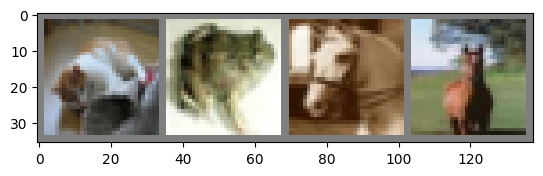

In [37]:
def show_images(img, mean, std):
    # Un-normalize the image and plot it
    mean = torch.tensor(mean, device=img.device)
    std = torch.tensor(std, device=img.device)
    img = img.permute(1, 2, 0)
    img = img * std + mean
    plt.imshow(img.numpy())


# fetch a batch from the train dataset
dataiter = iter(cifar_train_loader)
images, labels = next(dataiter)
nimages = min(batch_size, 4)
norm = preprocess.transforms[-1]
show_images(torchvision.utils.make_grid(images[:nimages]), norm.mean, norm.std)
# print labels
print(' '.join('%5s' % cifar_train.classes[labels[j]] for j in range(nimages)))

## 1.2 Baseline network

The SimpleNet class below inherits from the nn.Module class, which is a base class for all neural network modules in PyTorch. The __init__ method initializes the various layers of the neural network, while the forward method defines the forward pass through the network. Notice that you don't have to implement the backward pass when using superpositions of standard functions and layers, since the corresponding backward pass is already implemented for these standard operations, and the backward pass for your full model is simply derived from those using the chain rule.

Our network consists of two convolutional layers (conv1 and conv2) followed by two fully connected layers (fc1 and fc2), and a final output layer (fc3) with 10 output units (one for each class in the CIFAR-10 dataset). It also has a 2x down-sampling `pool` layer (applied after both conv1 and conv2), and ReLU nonlinearities between the layers.

The input to the network is a batch of 32x32 color images (3 channels for RGB) and the output is a tensor of shape (batch_size, 10) representing the predicted class scores for each input image in the batch.

## Question 2. Given that the input size is 32x32, and `conv1` layer is a convolution with a 5x5 kernel, what is the output size of the `conv1` layer?

- Dimension = $
\frac{\text{Input Dimension} - \text{Kernel Size} + 2 \times \text{Padding}}{\text{Stride}} + 1
$
$
= \frac{32 - 5 + 2 \times 0}{1} + 1 = 28
$

Since, `convo1` has output channel size of 6.
Therefore the dimensions of `convo1` is 6 x 28 x 28

## Question 3. Why does `fc1` have 16 * 5 * 5 = 400 input features?
1. `convo1` reduces the input size from 32x32 to 28x28 with 6 output channels.
2. `convo2` applies another 5x5 convoulution to further reduce the dimensions from 28x28 to 24x24 and outputs 16 channels
3. after each convolution layer theres a max `pooling layer` with a 2x2 kernel and stride 2, which halves the spatial dimensions. After 1st pooling layer the 28x28 output from `convo1` is reduced to 14x14. After 2nd pooling layer, the 24x24 output from `convo2` is reduced to 5x5.
4. `flattening` is the final feature map passed to fc1 (16 channels)

Therefore results in 16 x 5 x 5 = 400 input features.

In [38]:
class SimpleNet(nn.Module):
    def __init__(self, input_size=32, num_classes=10):
        # define the layers of the network
        super(SimpleNet, self).__init__()
        # 3 input channels: RGB
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        # num_classes output channels
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # Remember to use nonlinearities after hidden linear layers (conv, fc)
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Reshape as a vector
        x = x.view(-1, self.fc1.in_features)
        # Fully connected (fc) layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Note that the output layer does not need a nonlinearity.
        # as it models log-probability
        x = self.fc3(x)
        return x


model_simple = SimpleNet()
model_simple = to_device(model_simple)

## 1.3 Training and testing the network

In order to train the network, we are still missing a couple things:
1. A loss criterion: for most classification problems, cross-entropy is used to define loss. Luckily, we know ground truth labels for our training dataset, and our network already models log-probability output with its final fully connected layer.

2. An optimizer: we will use SGD with momentum as our base optimizer. You will have to tune its parameters later, and feel free to explore other optimizers available in the `optim` package!

## Question 4. As discussed in the lectures, cross-entropy is just a negative log-likelihood for the label data distribution. For M-class classification (M=10 for CIFAR-10), `label` is a random variable that takes one of M values: $target \in {1, \dots, M}$. What class of distributions does `label` belong to then (e.g. Gaussian, Binomial, etc.)? What are the parameters of the distribution in terms of the notations used in our formula below?

$$L = -\sum\limits_{j=1}^M [target = j]\log(p_j) = -\log(p_{target})$$

The training code runs over the dataset `nepoch` number of times (epochs).

- This label is modeled as a categorical distribution  because it represents a variable that can assume one of $M$ dinstinct classes with specified probabilities.
- The parameters of a categorical distribution are the probability $p_j$ for each class $j$, where $j=1,...,M$. These probabilities are often denoted as  $p_1, p_2,...,p_m$, where $\sum\limits_{j=1}^M p_j = 1$ and each $p_j$ is a probability between 0 and 1.
- In the cross entropy formula $p_target$ is the probability assigned to the correct class by the model, and it is the probability that the model predicts for the true label of the input. $[target=j]$ is an indicator that equals 1 if the target class is j and 0 otherwise. Which simplifies the sum to $ -\log(p_{target})$ for the label.

## TODO #1: implement the testing loop

While training code is provided below, you have to implement the testing routine. It's very similar to training, even simpler, as there is no need to make a call into the optimization step! You also have to loop through the data and get network outputs. Instead of computing the loss, let's measure the accuracy of the predictions:
$$\text{accuracy} = \dfrac{\text{number_of_correct_predictions}}{\text{total_samples}} * 100 \%$$

Use `torch.max()` to get the most likely label for every image from its per-class scores.

In [39]:
def test(model, loader):
    # Testing loop
    # Make sure to set the network to the testing mode
    # torch.no_grad() makes sure extra resources are not
    # allocated during the network run as backward pass is not needed
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():

        ###################################################
        # TODO: write your code here
        # Return the accuracy
        # Hint: look at the training code below for reference!
        ###################################################

        for inputs, labels in loader:
          inputs = to_device(inputs)
          labels = to_device(labels)
          outputs = model(inputs)

          _,predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def train_and_test(model, nepochs,
                   train_loader, test_loader,
                   optimizer=optim.SGD,
                   optimizer_params=None):

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), **optimizer_params)

    for epoch in range(nepochs):
        print("Epoch {}/{}".format(epoch + 1, nepochs))

        # Training loop
        # Some networks have different behavior for training and testing,
        # for example when BatchNorm or Dropout is used.
        # Make sure to set the network to the training mode.
        model.train()
        for inputs, labels in tqdm(train_loader):
            inputs = to_device(inputs)
            labels = to_device(labels)

            # Zero out the gradients before every iteration!
            optimizer.zero_grad()

            # forward + backward + optimizer step
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        accuracy = test(model, test_loader)
        print('Epoch {}, Test Accuracy: {:.2f}%'.format(epoch+1, accuracy))

In [40]:
optimizer_params_default = {
    "lr": 2e-3,
    "momentum": 0.9,
}
train_and_test(model_simple, 2, cifar_train_loader, cifar_test_loader,
               optimizer_params=optimizer_params_default)

Epoch 1/2


100%|██████████| 1563/1563 [00:30<00:00, 51.63it/s]


Epoch 1, Test Accuracy: 38.66%
Epoch 2/2


100%|██████████| 1563/1563 [00:32<00:00, 47.90it/s]


Epoch 2, Test Accuracy: 48.06%


## Question 5. What accuracy did you get with our simple network and the default settings? Is it good or bad? What is a "bad" accuracy for this problem (i.e. what accuracy level immediately hints at a presence of a bug in the code rather than at a need to design a better network)?
- Our SimpleNet model achived accuracy of 35-50% range. The accuracy level is relatively low for CIFAR-10, meaning that SimpleNet lacks the capacity to capture complex patterns in the data. A "bad" accuracy would be around 10%. This suggests that the model is not learning any meaningful patterns.

Now let's look at some predictions


GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog
GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog
Predicted:     cat  ship automobile  ship  frog  frog automobile  frog


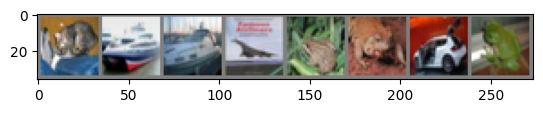

In [41]:
dataiter = iter(cifar_test_loader)
images, labels = next(dataiter)

# print images
nimages = min(batch_size, 8)
norm = cifar_test.transform.transforms[-1]
show_images(torchvision.utils.make_grid(images[:nimages]), norm.mean, norm.std)
print('GroundTruth: ', ' '.join('%5s' % cifar_test.classes[labels[j]] for j in range(nimages)))

###################################################
# TODO: write your code here
# Print out the network predictions
###################################################

model_simple.eval()

# Forward pass through the model to get predictions
outputs = model_simple(images.to("cuda" if torch.cuda.is_available() else "cpu"))
_, predicted = torch.max(outputs, 1)  # Get the indices of the highest-scoring classes

print('GroundTruth: ', ' '.join('%5s' % cifar_test.classes[labels[j]] for j in range(nimages)))
print('Predicted:  ', ' '.join('%5s' % cifar_test.classes[predicted[j]] for j in range(nimages)))


# 2. Design your own architecture

You can start exploring the space of architectures by tuning the hyperparameters of our baseline network first. Hyperparameters are variables that are not learned from the data, but rather set before the training process begins. They affect how the model is trained and can significantly impact its performance. Those are, for example, learning rate, number of layers (depth), number of neurons per layer (width).

Choosing appropriate hyperparameters is crucial for achieving good performance, and is often done through a combination of trial and error and intuition based on prior experience.


Let's reserve a small validation set for parameter tuning out of our testing data, and test our final model on the test set, minus the validation set.


In [42]:
# Split the test set into val and test_minus_val (20% and 80%, respectively)
# Use manual seed for results repeatability.
generator = torch.Generator().manual_seed(42)
cifar_val, cifar_test_minus_val = random_split(cifar_test, [0.2, 0.8],
                                               generator=generator)

cifar_val_loader = torch.utils.data.DataLoader(
    cifar_val, batch_size=batch_size, shuffle=False, num_workers=2)
cifar_test_minus_val_loader = torch.utils.data.DataLoader(
    cifar_test_minus_val, batch_size=batch_size, shuffle=False, num_workers=2)


## Question 6. Why is it important to have a validation set for parameter tuning?
- A validation set is crucial for parameter tuning because it allows us to access the model's performance on the data when its not pre-trained. The main reason is that it prevents overfitting, optimization, early stoppings and model selections.

Try tuning your parameters, and then modify the architecture, adding layers, normalization techniques, etc. from Pytorch's `nn` package.

## TODO #2: Implement a stronger network and achieve high accuracy on CIFAR-10

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Use 2048 as input features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with batch norm and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))  # No pooling after conv4

        # Flatten the tensor
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, 128 * 4 * 4]

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer for logits
        return x


model_custom = CustomNet()
model_custom = to_device(model_custom)
optimizer_params_custom = {
    "lr": 2e-3,
    "momentum": 0.9,
}
train_and_test(model_custom, 2, cifar_train_loader, cifar_val_loader,
               optimizer_params=optimizer_params_custom)

Epoch 1/2


100%|██████████| 1563/1563 [02:39<00:00,  9.78it/s]


Epoch 1, Test Accuracy: 63.45%
Epoch 2/2


100%|██████████| 1563/1563 [02:42<00:00,  9.64it/s]


Epoch 2, Test Accuracy: 69.80%


After you are done tuning the architecture structure and the hyperparameters, report your results with both CustomNet and SimpleNet on the `train_minus_val` split below. Discuss your resulting architecture in the report.

In [44]:
accuracy_simple = test(model_simple, cifar_test_minus_val_loader)
print('Baseline model accuracy (test_minus_val): {:.2f}%'.format(accuracy_simple))

accuracy_custom = test(model_custom, cifar_test_minus_val_loader)
print('Custom model accuracy (test_minus_val): {:.2f}%'.format(accuracy_custom))

Baseline model accuracy (test_minus_val): 47.92%
Custom model accuracy (test_minus_val): 69.69%


# 3. Dogs-vs-Cats and model tuning

Let's now explore some images with higher resolution than those of 32x32 from CIFAR. One of the popular classification datasets is ["Dogs vs Cats"](https://www.kaggle.com/c/dogs-vs-cats/data). We will use a smaller version of the dataset here, picking 2000 images subset for training. Let's download and extract the archive to the /tmp folder.

--2024-10-31 02:47:15--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   159MB/s    in 0.4s    

2024-10-31 02:47:16 (159 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



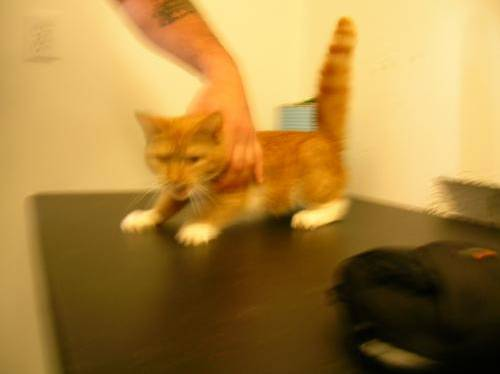

In [45]:
# Download the dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Unzip it to /tmp
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Create a PyTorch ImageFolder Dataset
train_data = ImageFolder("/tmp/cats_and_dogs_filtered/train")
train_data[0][0]

Let's see how our simple (or your custom) model trained on CIFAR does on these images. For this one, mine predicted a `truck` class as a top prediction with 41.3% confidence. If yours predicted a cat: great! But how does it do on other images? Try a few more changing the `sample_idx` below.

## Question 7. What is/are the main reason(s) for our SimpleNet and CustomNet to not work so well in this case, given that CIFAR-10 has both `dog` and `cat` labels?

- CIFAR-10 images are low-resolution (32x32) pixels and simplified, while `dog` and `cat` dataset typicall has much higher resolution and more complex features. SimpleNet and CustomNet are designed for simplier images, and lack the depth, capacity, and pre-training.

airplane: 25.6%


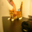

In [46]:
def get_prediction(img, model, preprocess=None, class_names=None):
    batch = preprocess(img) if preprocess is not None else img
    batch = batch.unsqueeze(0)
    batch = to_device(batch)
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = class_names[class_id] if class_names is not None else class_id
    return category_name, score

sample_idx = 0
img = train_data[sample_idx][0]
img = img.resize((32, 32))
category_name, score = get_prediction(
    img, model_custom, cifar_train.transforms.transform, cifar_train.classes)
print(f"{category_name}: {100 * score:.1f}%")
img

## Fine tuning

Fine-tuning is the process of taking a strong pre-trained model and adapting it to a new dataset by training it further. Our pre-trained model is a 50-layer ResNet architecture, trained on the large ImageNet dataset to distinguish between 1000 classes.

Fine-tuning involves freezing the weights of the lower layers in the pre-trained model, which are responsible for low-level features such as edges and textures, and training the upper layers on the new dataset. The weights in the upper layers are initialized randomly and then updated through backpropagation during training.

We want to leverage the features of the ResNet and consider an extreme case, when all the layers are frozen, except for the last linear (fully connected) layer.

In [47]:
# Imagenet accuracy: 80.858%
weights=ResNet50_Weights.DEFAULT
model_resnet = resnet50(weights=weights)
model_resnet = to_device(model_resnet)

ImageNet doesn't have a simple `cat` class: it rather has several classes such as `Egyptian cat`, `tabby cat`, etc. Assigning a cat to a wrong breed is considered the same as assigning a completely unrelated label. For example `sample_idx=3` is assigned to a `lynx` label (reasonable?), while `sample_idx=40` is assigned a `chihuahua` label as cats don't fall under the ImageNet specific breeds.

lynx: 0.2%


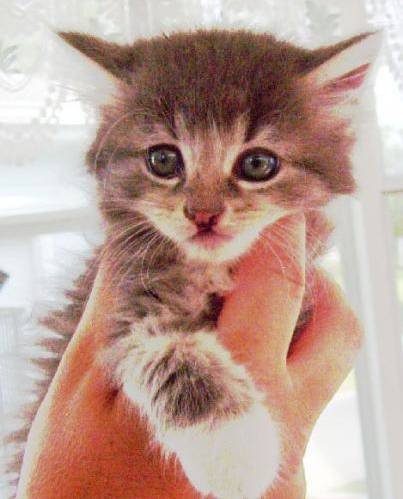

In [48]:
sample_idx = 3
img = train_data[sample_idx][0]
category_name, score = get_prediction(img, model_resnet, weights.transforms(),
                                      weights.meta["categories"])
print(f"{category_name}: {100 * score:.1f}%")
img

## TODO #3: Fine-tune the ResNet

Let's fine-tune the pre-trained ResNet. This involves the following steps:
1. freeze the pretrained layers;
2. modify the output to match the Dogs-vs-Cats class: you can simply change the `model_resnet.fc` output layer: there's no need to write new classes (e.g. if you wanted the last layer to be a convolution, you could re-define it as `model_resnet.fc = nn.Conv2D(3, 4, 5)`);
3. run `train_and_test` with appropriate arguments.

Can you achieve high accuracy now? Discuss your ResNet results (can be a part of your answer to Question 7).

- Yes, fine tuning the pre trained ResNet-50 model can achieve high accuracy on the `dog` and `cat` dataset. You can achieve this by freezing the earlier layers and modifying only the final fully connected layer to output two classes for `dog` and `cat`. The results after fine tuning pre-trained ResNet outputted high accuracy of 96-99%.

In [49]:
# Dogs-vs-Cats train and test sets
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
catsdogs_train = ImageFolder("/tmp/cats_and_dogs_filtered/train", transform=train_transforms)
catsdogs_test = ImageFolder("/tmp/cats_and_dogs_filtered/validation", transform=test_transforms)

# Freeze the parameters
for param in model_resnet.parameters():
    param.requires_grad = False


###################################################
# TODO: write your code here
# Modify the ResNet, and fine-tune to Dogs-vs-Cats
###################################################
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

model_resnet = models.resnet50(pretrained=True)

# Freeze all layers
for param in model_resnet.parameters():
    param.requires_grad = False

# Modify the final layer to match Dogs-vs-Cats classes (2 classes)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)

# Move model to device (GPU if available)
model_resnet = to_device(model_resnet)

# Define data loaders for training and testing
batch_size = 32
train_loader = DataLoader(catsdogs_train, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(catsdogs_test, batch_size=batch_size, shuffle=False, num_workers=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)

def fine_tune_resnet(model, train_loader, test_loader, criterion, optimizer, epochs=5):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = to_device(inputs)
            labels = to_device(labels)

            optimizer.zero_grad() # Zero out gradients for the optimizer

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

        test_accuracy = test(model, test_loader)
        print(f"Test Accuracy after epoch {epoch+1}: {test_accuracy:.2f}%")

fine_tune_resnet(model_resnet, train_loader, test_loader, criterion, optimizer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.3345
Test Accuracy after epoch 1: 98.20%
Epoch [2/5], Loss: 0.1594
Test Accuracy after epoch 2: 98.30%
Epoch [3/5], Loss: 0.1432
Test Accuracy after epoch 3: 98.50%
Epoch [4/5], Loss: 0.1271
Test Accuracy after epoch 4: 98.70%
Epoch [5/5], Loss: 0.1251
Test Accuracy after epoch 5: 98.60%


## 4. Beyond image classification

So far we looked only at the image classification task, which seems like a very narrow (and easy?) problem. But in fact, image classification networks are used as a core (backbone) for most of the image recognition problems.

Our fine-tuned network distinguishes cats from dogs, but it also gives us its prediction confidence. Let's try to use this confidence to add (some) localization capabilities to the network.

Object localization, or object detection involves modifying the network architecture to output both a class label for the input image and a bounding box that specifies the location of the object in the image. We won't build a complete detector, but we will make a step towards creating a region proposal network that says how likely a selected region contains an object of interest.

Imagine that you know the size of the object you are looking for. For instance, in the image below, assume you know that you look for objects that occupy about 3% of the image that fit into a square of size $K \times K$. For the image below, that would mean that the square has a side of $K = 170$ pixels. Let's see what confidence our network has for a random patch of size $K \times K$ and for a patch that is centered on the dog.

This may sound counterintuitive from the first glance that this process has any meaning. Our network can only predict `cat` or `dog` class, and we are asking it to classify a patch of the sky or forest! However, the fact that the network doesn't see any cat or dog features in the patch will hopefully push it towards predicting the corresponding class with a lower confidence.

--2024-10-31 03:54:13--  https://www.blossomsfield.co.uk/wp-content/uploads/2020/10/WhatsApp-Image-2020-10-06-at-12.43.20.jpeg
Resolving www.blossomsfield.co.uk (www.blossomsfield.co.uk)... 160.153.133.177
Connecting to www.blossomsfield.co.uk (www.blossomsfield.co.uk)|160.153.133.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288108 (281K) [image/jpeg]
Saving to: ‘/tmp/localize.jpeg’

/tmp/localize.jpeg  100%[===================>] 281.36K   357KB/s    in 0.8s    

2024-10-31 03:54:15 (357 KB/s) - ‘/tmp/localize.jpeg’ saved [288108/288108]



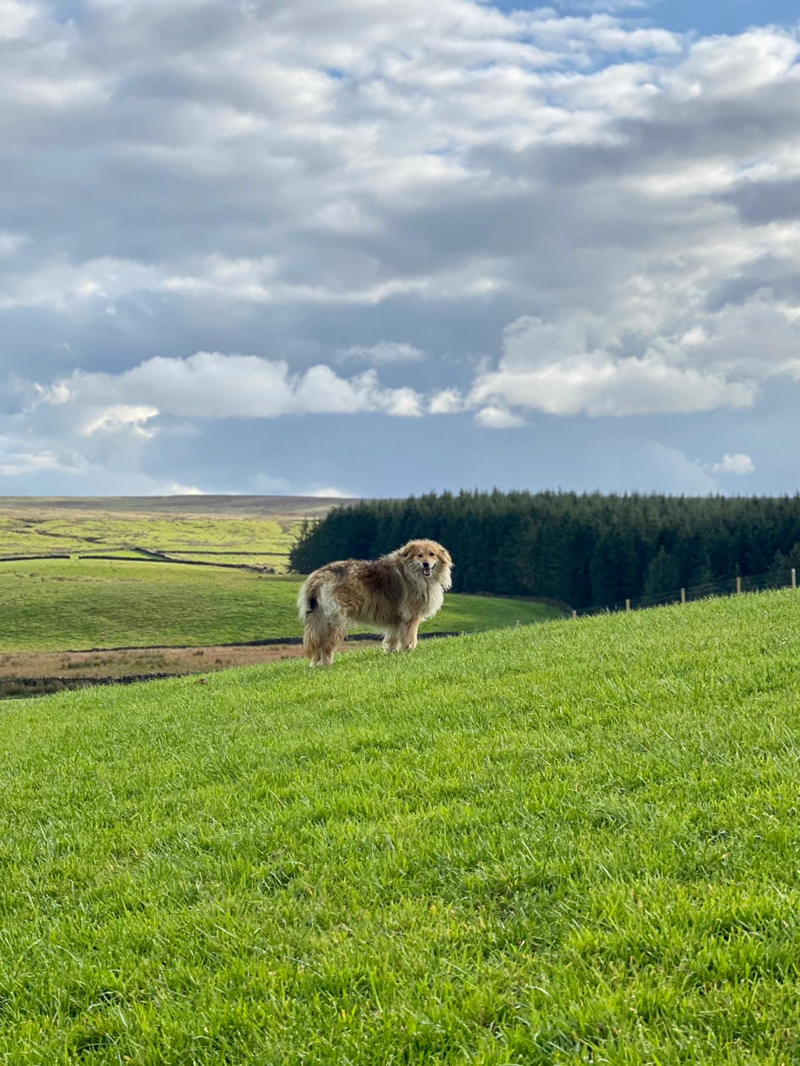

In [50]:
# Load a high rest image containing a dog and display it.
!wget https://www.blossomsfield.co.uk/wp-content/uploads/2020/10/WhatsApp-Image-2020-10-06-at-12.43.20.jpeg \
      -O /tmp/localize.jpeg
img = Image.open("/tmp/localize.jpeg")
width, height = img.size
width, height = 800, int(height * 800 / width)
img = img.resize((width, height))
img

dogs: 96.1%


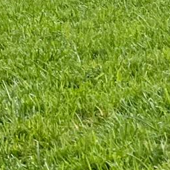

In [51]:
# Running our fine-tuned ResNet on a background patch.
left = 35
upper = 740
size = 170
box_random = (left, upper, left + size, upper + size)
crop_random = img.crop(box_random)
category_name_random, score_random = get_prediction(
    crop_random, model_resnet, test_transforms, catsdogs_test.classes)
print(f"{category_name_random}: {100 * score_random:.1f}%")
crop_random

dogs: 96.9%


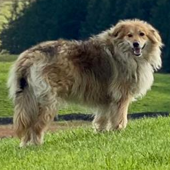

In [52]:
# Running our fine-tuned ResNet on a dog patch.
left = 290
upper = 520
size = 170
box_center = (left, upper, left + size, upper + size)
crop_center = img.crop(box_center)
category_name_center, score_center = get_prediction(
    crop_center, model_resnet, test_transforms, catsdogs_test.classes)
print(f"{category_name_center}: {100 * score_center:.1f}%")
crop_center

Use the function below to draw a set of patches on top of the image.

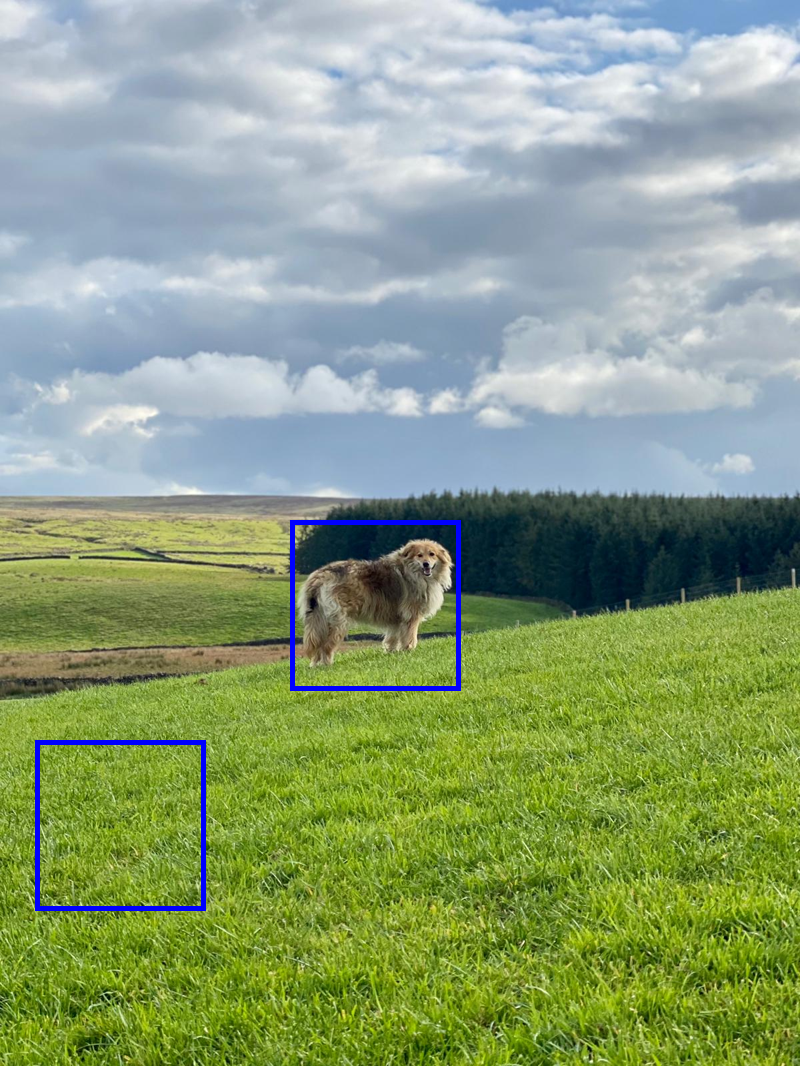

In [53]:
def draw(boxes, scores, color=(255, 0, 0)):
    width, height = img.size
    nboxes = len(boxes)
    pad = 10
    im2show = img.copy()
    img_draw = ImageDraw.Draw(im2show)
    for i, box in enumerate(boxes):
        score = scores[i]
        img_draw.rectangle(box, outline=color, width=5)

    return im2show

boxes = [box_center, box_random]
names = [category_name_center, category_name_random]
scores = [score_center, score_random]
im2show = draw(boxes, scores, color="blue")
im2show

## TODO #4: Implement the sliding window and visualize the most and the least confident predictions

Let's produce a set of candidates in a sliding window fashion. That is, place a window of size $K \times K$ into the top left corner, and evaluate the score of the corresponding crop to contain class `dog`. Now slide this window across all possible locations with step $s$ (i.e. evaluate a crop of size $K \times K$ with the top left corner coordinate $(0, s)$ next). Record all window positions and the corresponding scores for the `dog` class. Then sort them and plot top-20 and bottom-20 scoring ones. Pick $s$ yourself, and $K = 170$.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision.transforms as transforms

# Helper function to get prediction for a cropped window
def get_prediction(img, model, transform, class_names):
    img_tensor = transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    score = output[0][predicted.item()].item()
    return class_names[predicted.item()], score

# Sliding window function
def sliding_window_localization(model, image, K=170, s=50, class_index=1):
    scores = []
    width, height = image.size
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Slide window across image
    for y in range(0, height - K + 1, s):
        for x in range(0, width - K + 1, s):
            window = image.crop((x, y, x + K, y + K))
            _, dog_score = get_prediction(window, model, transform, ["cat", "dog"])
            scores.append((dog_score, (x, y, x + K, y + K)))

    # Sort and retrieve top-20 and bottom-20 scoring windows
    scores.sort(key=lambda x: x[0], reverse=True)
    top_20 = scores[:20]
    bottom_20 = scores[-20:]

    # Extract scores and boxes separately for further use
    top_20_scores, top_20_boxes = zip(*top_20)
    bottom_20_scores, bottom_20_boxes = zip(*bottom_20)

    return top_20_scores, top_20_boxes, bottom_20_scores, bottom_20_boxes

top_20_scores, top_20_boxes, bottom_20_scores, bottom_20_boxes = sliding_window_localization(model_resnet, img, K=170, s=50)

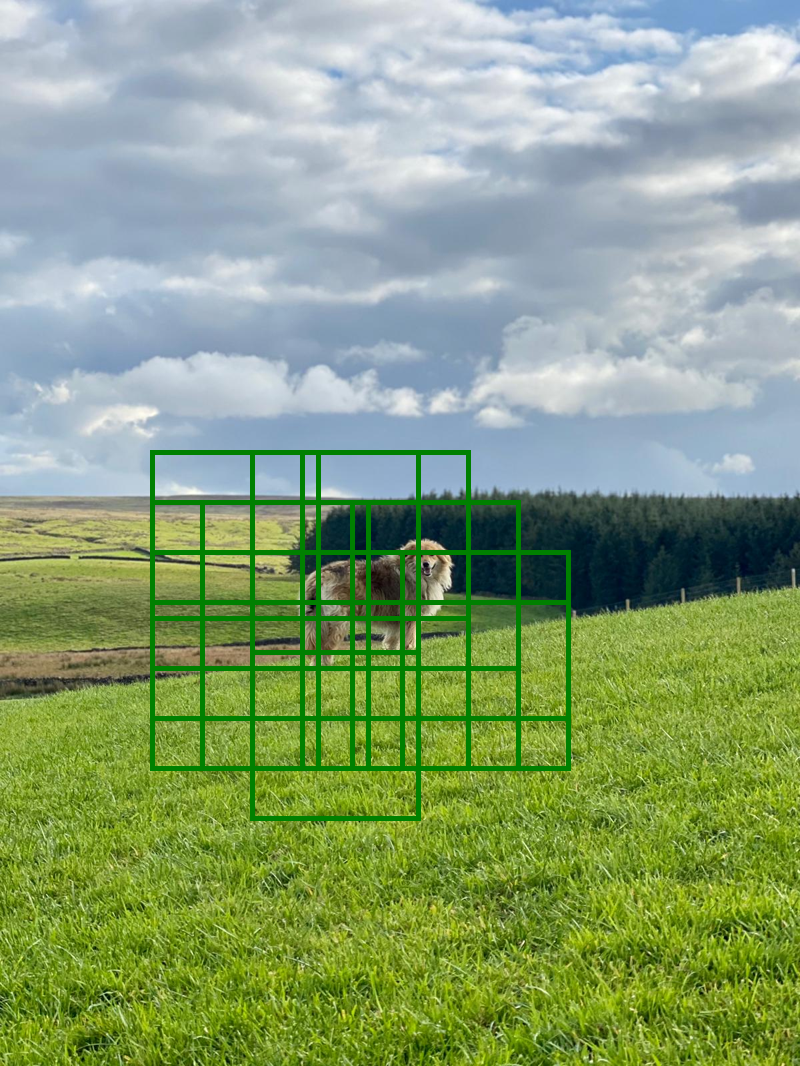

In [60]:
# Visualize the top-20 scoring boxes
# Changed default code of draw (boxes[20:], scores[20:], color="red"),
# did not use an array to store specfic values in boxes, scores
high_scoring_img = draw(top_20_boxes, top_20_scores, color="green")
high_scoring_img

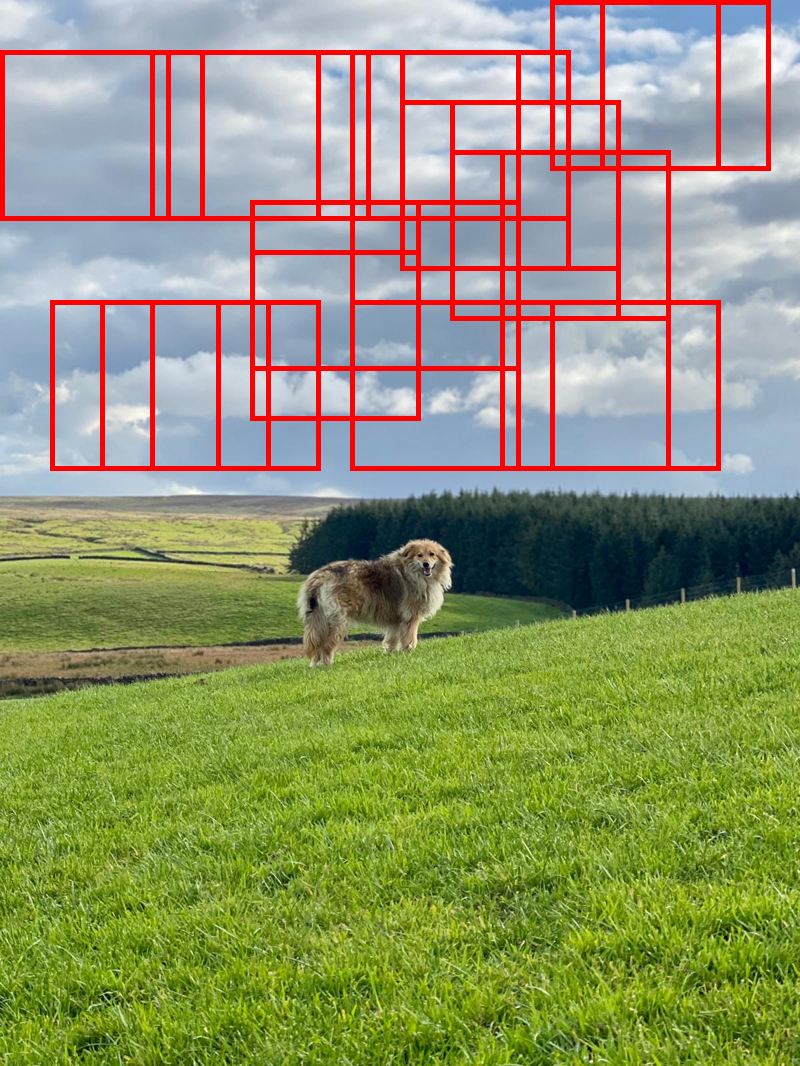

In [61]:
# Visualize the bottom-20 scoring boxes
# Changed default code of draw (boxes[-20:], scores[-20:], color="red"),
# did not use an array to store specfic values in boxes, scores
low_scoring_img = draw(bottom_20_boxes, bottom_20_scores, color="red")
low_scoring_img

Discuss your results: where did the top-20 scoring boxes land? How about the bottom-20 ones? Do any of the low scoring boxes still contain any pixels belonging to the dog? Why might that be (i.e. why a set of pixels belonging to the dog may score lower than a corner box with just the sky or just the grass)? Answer this final question as well in your report:

- The top-20 scoring boxes generally land around the `dog`. Particularly on parts like the face, ears, and body because these are regions where the model detected features that is associated with the `dog` class. Their fur texture or specific shapes that resemble dog-like features.

- The bottom-20 scoring boxes tend to appear in areas without any clear dog features such as the sky, trees, landscapes (background), or grassy areas. These regions detect less features associated with the `dog` class. However, some low-scoring boxes may still contain parts of the dog; include edges of the fur where it doesn't include any distinct features of `dog`.

- Some low-scoring boxes that contains pixels of the dog are likely focusing on less distinctive parts (small patches of fur or edges of the body). The model might not recognize these as part of a `dog` due to insufficient context or lack of prominent features (eyes, nose, face shape) that the model has learned to associate with the `dog`.

## Question 8. What drawbacks does such an approach of creating region proposals have? What extra steps do you need to make to create a real detector?

- The drawbacks of the approach of creating region proposals have lack of context awareness, inefficiency, fixed window size and position, and no refinement of bounding boxes.

- Extra steps need to create a real detector are using region proposal network (RPN), incorporate content, implement multi-scale detection, refine and filter proposals, and end-to-end training with classification and localization losses.